# Pose Detection

In [2]:
!pip install greengrasssdk


In [3]:
from __future__ import division
import argparse, time, logging, os, math, tqdm, cv2
import uuid
import greengrasssdk


import boto3
import numpy as np
import mxnet as mx
from mxnet import gluon, nd, image
from mxnet.gluon.data.vision import transforms

import gluoncv as gcv
gcv.utils.check_version('0.6.0')
from gluoncv import data
from gluoncv.data import mscoco
from gluoncv.model_zoo import get_model
from gluoncv.data.transforms.pose import detector_to_simple_pose, heatmap_to_coord
from gluoncv.utils.viz import cv_plot_image, cv_plot_keypoints

from posture_analysis import PostureAnalysis

1. [Set Up](#1.-Set-Up)
2. [Select a pre-trained model](#2.-Select-a-pre-trained-model)
3. [Run inference on the pre-trained model](#3.-Run-inference-on-the-pre-trained-model)
    * [Retrieve Artifacts & Deploy an Endpoint](#3.1.-Retrieve-Artifacts-&-Deploy-an-Endpoint)
    * [Download example images for inference](#3.2.-Download-example-images-for-inference)
    * [Query endpoint and parse response](#3.3.-Query-endpoint-and-parse-response)
    * [Clean up the endpoint](#3.4.-Clean-up-the-endpoint)
4. [Fine-tune the pre-trained model on a custom dataset](#4.-Fine-tune-the-pre-trained-model-on-a-custome-dataset)
    * [Retrieve Training artifacts](#4.1.-Retrieve-Training-artifacts)
    * [Set Training parameters](#4.2.-Set-Training-parameters)
    * [Train with Automatic Model Tuning (HPO)](#AMT)
    * [Start Training](#4.4.-Start-Training)
    * [Deploy & run Inference on the fine-tuned model](#4.5.-Deploy-&-run-Inference-on-the-fine-tuned-model)
    * [Incrementally train the fine-tuned model](#4.6.-Incrementally-train-the-fine-tuned-model)

## 1. Set Up
***
Before executing the notebook, there are some initial steps required for setup. This notebook requires latest version of sagemaker and ipywidgets.
***

In [4]:
import sagemaker, boto3, json
import numpy as np
import cv2
import mxnet as mx
import math
import datetime
from sagemaker.session import Session
from matplotlib import pyplot as plt
import matplotlib.image as mpimg

sagemaker_session = Session()
aws_role = sagemaker_session.get_caller_identity_arn()
aws_region = boto3.Session().region_name
sess = sagemaker.Session()

Some Useful functions

## 2. Select a pre-trained model
***
You can continue with the default model, or can choose a different model from the dropdown generated upon running the next cell. A complete list of SageMaker pre-trained models can also be accessed at [Sagemaker pre-trained Models](https://sagemaker.readthedocs.io/en/stable/doc_utils/pretrainedmodels.html#).
***

In [5]:
frame = mpimg.imread('ChairPose_example.jpg')

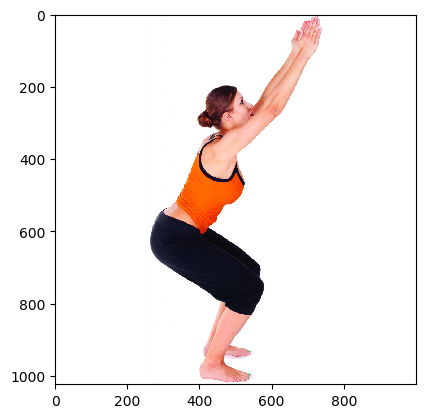

In [6]:
%matplotlib inline
plt.imshow(frame)
plt.show()

***
Select a different Sagemaker pre-trained model. Here, we download the model_manifest file from the Built-In Algorithms s3 bucket, filter-out all the Image Classification models and select a model for inference.
***

In [9]:
from gluoncv import model_zoo, data, utils
from gluoncv.data.transforms.pose import detector_to_simple_pose, heatmap_to_coord

### Load a pretrained model

You load two pre-trained models, one to detect people (yolo3_mobilenet1.0_coco) in the frame and one to detect the pose (simple_pose_resnet18_v1b) for each person detected. To load the pre-trained models, enter the following code in a new code cell: 

In [10]:
people_detector = model_zoo.get_model('yolo3_mobilenet1.0_coco', pretrained=True)
pose_detector = model_zoo.get_model('simple_pose_resnet18_v1b', pretrained=True)

Because the yolo_mobilenet1.0_coco pre-trained model is trained to detect many types of objects in addition to people, the code below narrows down the detection criteria to just people so that the model runs faster.

In [11]:
people_detector.reset_class(["person"], reuse_weights=['person'])

### Pre-process an image for detector, and make inference

The following code shows how to use the people detector to detect people in the frame. The outputs of the people detector are the class_IDs (just “person” in this use case because we’ve limited the model’s search scope), the confidence scores, and a bounding box around each person detected in the frame. 

This function returns two results. The first is a NDArray with shape (batch_size, RGB_channels, height, width). It can be fed into the model directly. The second one contains the images in numpy format to easy to be plotted. Since we only loaded a single image, the first dimension of x is 1.

In [12]:
img = mx.nd.array(frame)
x, img = data.transforms.presets.ssd.transform_test(img, short=256)


Let's detect people

In [13]:
class_IDs, scores, bounding_boxs = people_detector(x)

### Process tensor from detector to keypoint network

For a Simple Pose network, it expects the input has the size 256x192, and the human is centered. We crop the bounding boxed area for each human, and resize it to 256x192, then finally normalize it.

In order to make sure the bounding box has included the entire person, we usually slightly upscale the box size.



In [14]:
pose_input, upscale_bbox = detector_to_simple_pose(img, class_IDs, scores, bounding_boxs)

### Predict with a Simple Pose network

Now we can make prediction.

A Simple Pose network predicts the heatmap for each joint (i.e. keypoint). After the inference we search for the highest value in the heatmap and map it to the coordinates on the original image.

In [15]:
predicted_heatmap = pose_detector(pose_input)
pred_coords, confidence = heatmap_to_coord(predicted_heatmap, upscale_bbox)

### Pre-process an image for detector, and make inference¶
Using SageMaker, we can perform inference on the pre-trained model, even without fine-tuning it first on a custom dataset. For this example, that means on an input image, predicting the class label from one of the 1000 classes of the ImageNet dataset. 

**Bounding Box**: [x,y, width, height]


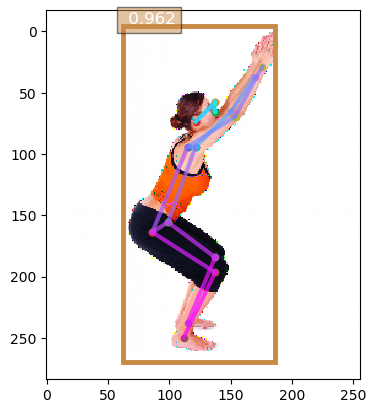

In [16]:
ax = utils.viz.plot_keypoints(img, pred_coords, confidence,
                              class_IDs, bounding_boxs,scores, box_thresh=0.2, keypoint_thresh=0.2)
plt.show(ax)

## Testing the posuter analysis module

In [17]:
postureAnalysis = PostureAnalysis()

In [18]:
client = boto3.client('dynamodb')

In [19]:
iot_topic = "xxxxx"
session = None
client = "xxx"
pose = "Chair Pose"

In [20]:
postureAnalysis.create_json(pose, pred_coords, confidence, bounding_boxs, scores, client,iot_topic,session)

before allJoints
after allJoints


'[{"SessionID": null, "Timestamp": "2022-11-09 22:31:31", "PersonID": 0, "Deviations": {"Right Lower Arm": {"Diff": 0.21180521636908622}, "Left Lower Arm": {"Diff": 12.457179845327694}, "Right Upper Arm": {"Diff": -11.114134450361789}, "Left Upper Arm": {"Diff": -16.255915935813036}, "Right Thigh": {"Diff": -8.333216121645414}, "Left Thigh": {"Diff": -12.457163108434074}, "Hips": {"Diff": -32.5428253044841}, "Shoulders": {"Diff": 0.0}}}]'

In [18]:
pred_coords_clean = pred_coords.asnumpy()
confidence_clean = confidence.asnumpy()
bounding_boxs_clean = bounding_boxs.asnumpy()
scores_clean = scores.asnumpy()

In [19]:
pred_coords


[[[154.66669   56.265625]
  [154.66669   51.9375  ]
  [149.33331   51.9375  ]
  [154.66669   51.9375  ]
  [128.        56.265625]
  [160.        82.234375]
  [106.66666   77.90625 ]
  [186.66669   86.5625  ]
  [ 64.        77.90625 ]
  [224.        82.234375]
  [ 26.666672  64.921875]
  [144.       160.14062 ]
  [112.       160.14062 ]
  [170.66669  203.42188 ]
  [ 90.66666  207.75    ]
  [160.       246.70312 ]
  [ 69.33334  251.03125 ]]]
<NDArray 1x17x2 @cpu(0)>

#### **BodyParts Result JSON format:**

We work on this one

In [18]:
keys_Joints = ['Nose', 'Right Eye', 'Left Eye', 'Right Ear','Left Ear','Right Shoulder',
         'Left Shoulder','Right Elbow','Left Elbow','Right Wrist','Left Wrist','Right Hip',
         'Left Hip','Right Knee','Left Knee','Right Ankle','Left Ankle']

In [19]:
allJoints = [{name:Joint(name,coord[0],coord[1],conf[0]) for name,coord,conf in zip(keys_Joints, coord_per_person, conf_per_person)} 
                  for coord_per_person, conf_per_person in zip(pred_coords_clean,confidence_clean)]

Definition of Body

In [20]:
BodyForm = {
    'Right Lower Arm': ['Right Shoulder','Right Elbow'],
    'Left Lower Arm': ['Left Shoulder','Left Elbow'],
    'Right Upper Arm': ['Right Elbow', 'Right Wrist'],
    'Left Upper Arm': ['Left Elbow', 'Left Wrist'],
    'Right Thigh': ['Right Hip', 'Right Knee'],
    'Left Thigh': ['Left Hip', 'Left Knee'],
    'Hips': ['Left Hip', 'Right Hip'],
    'Shoulders': ['Left Shoulder', 'Right Shoulder'],
}

Creating the body class frm joints

In [21]:
allBodyparts = []
for joint in allJoints:
    iter_body = {}
    for bodypart_name, joint_names in BodyForm.items():
        body = Bodypart(bodypart_name, joint[joint_names[0]], joint[joint_names[1]])
        body.get_metrics()
        iter_body.update({bodypart_name:body})
    allBodyparts.append(iter_body)

#### **Global Picture Result JSON format:**

In [22]:
keys_BoundingBox = ["X0","Y0", "Width", "Height"]

In [23]:
resBoundingBox = [{"BoundingBox":{"Coords":{key:float(value) for key,value in zip(keys_BoundingBox,Boundingbox_per_person[0])}
                       ,"Confidence":float(conf_per_person[0][0])}}
                  for Boundingbox_per_person, conf_per_person in zip(bounding_boxs_clean,scores_clean)]

In [24]:
paramsJoints = []
for allJoints_pp in allJoints:
    paramsJoints_pp = {}
    for joint_name in keys_Joints:
        joint = allJoints_pp[joint_name]
        paramsJoints_pp.update({joint_name:{"Coords":joint.coords, "Conf":joint.conf}})
    paramsJoints.append(paramsJoints_pp)

In [3]:
paramsBodyparts = []
for allBodyparts_pp in allBodyparts:
    paramsBodyparts_pp = {}
    for bodypart_name in BodyForm:
        body = allBodyparts_pp[bodypart_name]
        paramsBodyparts_pp.update({bodypart_name:{"Angle":body.orient, "Conf":body.conf}})
    paramsBodyparts.append(paramsBodyparts_pp)

NameError: name 'allBodyparts' is not defined

In [26]:
paramsBodyparts

[{'Right Lower Arm': {'Angle': 9.2189763110023, 'Conf': 0.7713455772347722},
  'Left Lower Arm': {'Angle': -0.0, 'Conf': 0.8447613297168033},
  'Right Upper Arm': {'Angle': -6.612892513761705, 'Conf': 0.7714088155711387},
  'Left Upper Arm': {'Angle': 19.177460304343136, 'Conf': 0.8068183399107198},
  'Right Thigh': {'Angle': 58.36171333527344, 'Conf': 0.7172508941184788},
  'Left Thigh': {'Angle': -65.86326709313359, 'Conf': 0.6752188672840589},
  'Hips': {'Angle': 0.0, 'Conf': 0.6752188672840589},
  'Shoulders': {'Angle': 4.63951890548592, 'Conf': 0.8447613297168033}}]

In [27]:
ground_truth_angles = {'Right Lower Arm': {'GT Angle': 0.0},
  'Left Lower Arm': {'GT Angle': 0.0},
  'Right Upper Arm': {'GT Angle': -10.0},
  'Left Upper Arm': {'GT Angle': 10.0},
  'Right Thigh': {'GT Angle': 60},
  'Left Thigh': {'GT Angle': -60},
  'Hips': {'GT Angle': 0.0},
  'Shoulders': {'GT Angle': 0.0}}

In [35]:
deviations = []
for paramsBodyparts_pp in paramsBodyparts:
    deviations_pp = {}
    for bodypart_name, data in paramsBodyparts_pp.items():
        diff = data['Angle'] - ground_truth_angles[bodypart_name]['GT Angle']
        deviations_pp.update({bodypart_name:{'Diff':diff}})
    deviations.append(deviations_pp)

In [36]:
deviations

[{'Right Lower Arm': {'Diff': 9.2189763110023},
  'Left Lower Arm': {'Diff': -0.0},
  'Right Upper Arm': {'Diff': 3.3871074862382953},
  'Left Upper Arm': {'Diff': 9.177460304343136},
  'Right Thigh': {'Diff': -1.6382866647265573},
  'Left Thigh': {'Diff': -5.863267093133587},
  'Hips': {'Diff': 0.0},
  'Shoulders': {'Diff': 4.63951890548592}}]

Lt's combine all of these

In [37]:
time_now = datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")

In [38]:
res = [{"Timestamp":time_now,"PersonID":person,**Bbox, "Joints":Joint, "Bodyparts":Body, "Deviations": Devi} for person,(Bbox,Joint,Body, Devi)
       in enumerate(zip(resBoundingBox, paramsJoints, paramsBodyparts, deviations)) ]

In [39]:
res

[{'Timestamp': '2022-10-05 23:26:49',
  'PersonID': 0,
  'BoundingBox': {'Coords': {'X0': -6.771049499511719,
    'Y0': 20.183685302734375,
    'Width': 255.09011840820312,
    'Height': 275.97412109375},
   'Confidence': 0.982085645198822},
  'Joints': {'Nose': {'Coords': (154.66668701171875, 56.265625),
    'Conf': 0.9574321508407593},
   'Right Eye': {'Coords': (154.66668701171875, 51.9375),
    'Conf': 0.9435590505599976},
   'Left Eye': {'Coords': (149.33331298828125, 51.9375),
    'Conf': 0.9650167226791382},
   'Right Ear': {'Coords': (154.66668701171875, 51.9375),
    'Conf': 0.6708675026893616},
   'Left Ear': {'Coords': (128.0, 56.265625), 'Conf': 0.9615384340286255},
   'Right Shoulder': {'Coords': (160.0, 82.234375),
    'Conf': 0.8782628178596497},
   'Left Shoulder': {'Coords': (106.66665649414062, 77.90625),
    'Conf': 0.9191089868545532},
   'Right Elbow': {'Coords': (186.66668701171875, 86.5625),
    'Conf': 0.878298819065094},
   'Left Elbow': {'Coords': (64.0, 77.90

In [40]:
json_res = json.dumps(res)

In [41]:
json_res

'[{"Timestamp": "2022-10-05 23:26:49", "PersonID": 0, "BoundingBox": {"Coords": {"X0": -6.771049499511719, "Y0": 20.183685302734375, "Width": 255.09011840820312, "Height": 275.97412109375}, "Confidence": 0.982085645198822}, "Joints": {"Nose": {"Coords": [154.66668701171875, 56.265625], "Conf": 0.9574321508407593}, "Right Eye": {"Coords": [154.66668701171875, 51.9375], "Conf": 0.9435590505599976}, "Left Eye": {"Coords": [149.33331298828125, 51.9375], "Conf": 0.9650167226791382}, "Right Ear": {"Coords": [154.66668701171875, 51.9375], "Conf": 0.6708675026893616}, "Left Ear": {"Coords": [128.0, 56.265625], "Conf": 0.9615384340286255}, "Right Shoulder": {"Coords": [160.0, 82.234375], "Conf": 0.8782628178596497}, "Left Shoulder": {"Coords": [106.66665649414062, 77.90625], "Conf": 0.9191089868545532}, "Right Elbow": {"Coords": [186.66668701171875, 86.5625], "Conf": 0.878298819065094}, "Left Elbow": {"Coords": [64.0, 77.90625], "Conf": 0.8982306718826294}, "Right Wrist": {"Coords": [224.0, 82.